This notebook shows the application of LSTM to predict sea ice concentration from SST data, **trained on polar regions (Arctic >45°N and Antarctic <-45°S)** with visualization focused on the Greenland coastal region.

In [74]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import torch
import torch.nn as nn
from pathlib import Path
import urllib.request
import gzip
import shutil
import cartopy.crs as ccrs

from utils import *

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [75]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [76]:
cwd = os.getcwd()
data_dir = Path("hadisst_data")
data_dir.mkdir(exist_ok=True)

sst_url = "https://www.metoffice.gov.uk/hadobs/hadisst/data/HadISST_sst.nc.gz"
ice_url = "https://www.metoffice.gov.uk/hadobs/hadisst/data/HadISST_ice.nc.gz"

sst_gz = data_dir / "HadISST_sst.nc.gz"
ice_gz = data_dir / "HadISST_ice.nc.gz"
sst_nc = data_dir / "HadISST_sst.nc"
ice_nc = data_dir / "HadISST_ice.nc"

### 1. Data preprocessing: prepare data for training & test sets

#### Download and decompress data

In [77]:
def download_if_needed(url, path):
    if not path.exists():
        print(f"Downloading {path.name} ...")
        urllib.request.urlretrieve(url, path)
    else:
        print(f"{path.name} exists. Skipping download.")

def gunzip_if_needed(gz_path, nc_path):
    if not nc_path.exists():
        print(f"Decompressing {gz_path.name} ...")
        with gzip.open(gz_path, "rb") as fin, open(nc_path, "wb") as fout:
            shutil.copyfileobj(fin, fout)
    else:
        print(f"{nc_path.name} exists. Skipping decompress.")

download_if_needed(sst_url, sst_gz)
gunzip_if_needed(sst_gz, sst_nc)

download_if_needed(ice_url, ice_gz)
gunzip_if_needed(ice_gz, ice_nc)

HadISST_sst.nc.gz exists. Skipping download.
HadISST_sst.nc exists. Skipping decompress.
HadISST_ice.nc.gz exists. Skipping download.
HadISST_ice.nc exists. Skipping decompress.


#### Open, merge, and filter datasets

In [78]:
ds_sst = xr.open_dataset(sst_nc)
ds_ice = xr.open_dataset(ice_nc)

# pick correct ice variable
if "sic" in ds_ice.data_vars:
    ice_var = "sic"
elif "ice" in ds_ice.data_vars:
    ice_var = "ice"
else:
    ice_var = list(ds_ice.data_vars)[0]

ds_merged = xr.merge([
    ds_sst[["sst"]],
    ds_ice[[ice_var]].rename({ice_var: "ice"})
])

# Filter to POLAR REGIONS for training (Arctic: >45°N, Antarctic: <-45°S)
ds_arctic = ds_merged.sel(latitude=slice(90, 45))      # 90°N to 45°N (descending coords)
ds_antarctic = ds_merged.sel(latitude=slice(-45, -90)) # -45°S to -90°S (descending coords)

# Combine Arctic and Antarctic
ds_full = xr.concat([ds_arctic, ds_antarctic], dim="latitude")

print("Polar regions dataset shape:", ds_full.sst.shape)
print(f"Arctic: lat [{ds_arctic.latitude.values.min():.1f}, {ds_arctic.latitude.values.max():.1f}]")
print(f"Antarctic: lat [{ds_antarctic.latitude.values.min():.1f}, {ds_antarctic.latitude.values.max():.1f}]")

# Define Greenland region for TEST visualization only (used later)
greenland_lat_min, greenland_lat_max = 60, 85   # degrees North
greenland_lon_min, greenland_lon_max = -65, -10  # degrees East

Polar regions dataset shape: (1870, 90, 360)
Arctic: lat [45.5, 89.5]
Antarctic: lat [-89.5, -45.5]


#### Train/test split

In [79]:
train_end_year = "2010"
test_start_year = "2010"

# TRAINING: Polar regions (Arctic + Antarctic)
ds_train = ds_full.sel(time=slice(None, train_end_year))

# TESTING: Also polar regions (Arctic + Antarctic)
ds_test = ds_full.sel(time=slice(test_start_year, None))

print("Train (POLAR REGIONS):", ds_train.time.values[0], "→", ds_train.time.values[-1])
print("  Train shape:", ds_train.sst.shape)
print("Test (POLAR REGIONS):", ds_test.time.values[0], "→", ds_test.time.values[-1])
print("  Test shape:", ds_test.sst.shape)

Train (POLAR REGIONS): 1870-01-16T11:59:59.505615234 → 2010-12-16T12:00:00.000000000
  Train shape: (1692, 90, 360)
Test (POLAR REGIONS): 2010-01-16T12:00:00.000000000 → 2025-10-16T12:00:00.000000000
  Test shape: (190, 90, 360)


#### Stack to (time, space)

In [80]:
# Training data: POLAR REGIONS (Arctic + Antarctic)
X_train_raw = ds_train["sst"].stack(space=("latitude","longitude")).values
y_train_raw = ds_train["ice"].stack(space=("latitude","longitude")).values

# Test data: POLAR REGIONS (Arctic + Antarctic)
X_test_raw  = ds_test["sst"].stack(space=("latitude","longitude")).values
y_test_raw  = ds_test["ice"].stack(space=("latitude","longitude")).values

print("X_train_raw (POLAR):", X_train_raw.shape)
print("y_train_raw (POLAR):", y_train_raw.shape)
print("X_test_raw (POLAR):", X_test_raw.shape)
print("y_test_raw (POLAR):", y_test_raw.shape)

X_train_raw (POLAR): (1692, 32400)
y_train_raw (POLAR): (1692, 32400)
X_test_raw (POLAR): (190, 32400)
y_test_raw (POLAR): (190, 32400)


### 2. Feature engineering

#### Clean and normalize SST

In [81]:
# copies so we don't touch originals
X_train_clean = X_train_raw.copy()
X_test_clean  = X_test_raw.copy()

# HadISST uses large negative values (e.g., -1000) to indicate ice-covered areas
# Convert these to freezing point of seawater (~-1.8°C) instead of NaN
ice_mask_train = X_train_clean < -5
ice_mask_test  = X_test_clean < -5

X_train_clean[ice_mask_train] = -1.8
X_test_clean[ice_mask_test]   = -1.8

# Still mask unrealistic positive values
bad_train = X_train_clean > 40
bad_test  = X_test_clean > 40

X_train_clean[bad_train] = np.nan
X_test_clean[bad_test]   = np.nan

# normalize using ONLY training data (polar regions)
mean_sst = np.nanmean(X_train_clean)
std_sst  = np.nanstd(X_train_clean)

X_train_norm = (X_train_clean - mean_sst) / std_sst
X_test_norm  = (X_test_clean  - mean_sst) / std_sst

print("SST mean (POLAR train):", mean_sst)
print("SST std  (POLAR train):", std_sst)
print(f"Converted {ice_mask_train.sum():,} ice-covered train points to -1.8°C")

SST mean (POLAR train): 2.0671375
SST std  (POLAR train): 4.4865212
Converted 2,533,339 ice-covered train points to -1.8°C


#### Month sin/cos features

In [82]:
def month_features(time_coord):
    months = time_coord.dt.month.values
    phase = 2 * np.pi * (months - 1) / 12
    return np.sin(phase), np.cos(phase)

# Both train and test use polar regions
month_sin_train, month_cos_train = month_features(ds_train.time)
month_sin_test,  month_cos_test  = month_features(ds_test.time)

#### Lat/lon features

In [83]:
# Use polar regions lat/lon grid for both train and test
lats = ds_train.latitude.values
lons = ds_train.longitude.values
lat_grid, lon_grid = np.meshgrid(lats, lons, indexing="ij")

lat_space = lat_grid.reshape(-1)
lon_space = lon_grid.reshape(-1)

lat_norm = lat_space / 90.0
lon_norm = lon_space / 180.0

print(f"Spatial points (polar regions): {len(lat_norm):,}")

Spatial points (polar regions): 32,400


#### Reshape data to feed into the LSTM model

The LSTM needs data with the format of **[samples, time steps, features]**

Here the lag time step is set to **5**

In [99]:
def create_sequences_multi(X_sst, y_data,
                           month_sin, month_cos,
                           lat_norm, lon_norm,
                           slider):

    n_time, n_space = X_sst.shape
    X_list, y_list, meta = [], [], []

    for s in range(n_space):
        sst_col = X_sst[:, s]
        lat_val = lat_norm[s]
        lon_val = lon_norm[s]

        if np.all(np.isnan(sst_col)) or np.all(np.isnan(y_data[:,s])):
            continue

        for t in range(n_time - slider + 1):
            sst_win = sst_col[t:t+slider]
            y_val = y_data[t+slider-1, s]

            if np.isnan(sst_win).any() or np.isnan(y_val):
                continue

            feat = np.zeros((slider, 5), dtype=np.float32)
            feat[:,0] = sst_win
            feat[:,1] = month_sin[t:t+slider]
            feat[:,2] = month_cos[t:t+slider]
            feat[:,3] = lat_val
            feat[:,4] = lon_val

            X_list.append(feat)
            y_list.append(y_val)
            meta.append((t+slider-1, s))

    return np.stack(X_list), np.array(y_list).reshape(-1,1), np.array(meta)

slider = 5

# TRAINING sequences: POLAR REGIONS
X_train_seq, y_train_seq, meta_train = create_sequences_multi(
    X_train_norm, y_train_raw,
    month_sin_train, month_cos_train,
    lat_norm, lon_norm,
    slider
)

# TEST sequences: POLAR REGIONS
X_test_seq, y_test_seq, meta_test = create_sequences_multi(
    X_test_norm, y_test_raw,
    month_sin_test, month_cos_test,
    lat_norm, lon_norm,
    slider
)

print("X_train_seq shape (POLAR):", X_train_seq.shape)
print("y_train_seq shape (POLAR):", y_train_seq.shape)
print("X_test_seq shape (POLAR):", X_test_seq.shape)


X_train_seq shape (POLAR): (31943712, 5, 5)
y_train_seq shape (POLAR): (31943712, 1)
X_test_seq shape (POLAR): (3519864, 5, 5)


In [100]:
# Polar regions training data is larger than Greenland alone - subsample for tractable training
# Adjust this fraction based on your computational resources
subsample_fraction = 0.05  

n_total = len(X_train_seq)
n_subsample = int(n_total * subsample_fraction)

# Random subsample
np.random.seed(42)
subsample_idx = np.random.choice(n_total, n_subsample, replace=False)

X_train_seq_sub = X_train_seq[subsample_idx]
y_train_seq_sub = y_train_seq[subsample_idx]
meta_train_sub = meta_train[subsample_idx]

print(f"Original polar training samples: {n_total:,}")
print(f"Subsampled to: {n_subsample:,} ({subsample_fraction*100:.1f}%)")

# Use subsampled data for training
X_train_seq = X_train_seq_sub
y_train_seq = y_train_seq_sub
meta_train = meta_train_sub

Original polar training samples: 31,943,712
Subsampled to: 1,597,185 (5.0%)


In [101]:
# Convert to PyTorch datasets
train_dataset = torch.utils.data.TensorDataset(torch.FloatTensor(X_train_seq),
                                               torch.FloatTensor(y_train_seq))
test_dataset = torch.utils.data.TensorDataset(torch.FloatTensor(X_test_seq))

# Split into train and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

### 3. Define the LSTM structure

In [102]:
# set hyperparameters
n_neuron       = 64
activation     = 'ReLU'
num_epochs     = 50
learning_rate  = 0.001
minibatch_size = 256
model_num      = 1

In [103]:
# Create data loaders for batched training
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=minibatch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=minibatch_size, shuffle=False)

In [104]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, activation="ReLU", num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            getattr(nn, activation)(),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        out, _ = self.lstm(x)        # [batch, seq_len, hidden]
        x = out[:, -1, :]            # last timestep output
        x = self.fc(x)
        return x

model = LSTMModel(
    input_size=X_train_seq.shape[2],
    hidden_size=n_neuron,
    output_size=y_train_seq.shape[-1],
    activation=activation,
    num_layers=2
)

print(model)

LSTMModel(
  (lstm): LSTM(5, 64, num_layers=2, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)


In [105]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

In [106]:
model.to(device)
print("X_train_seq shape:", X_train_seq.shape)

X_train_seq shape: (1597185, 5, 5)


### 4. Train & save the NN model

In [107]:
from utils import pytorch_train
train_losses_mse, val_losses_mse = pytorch_train(model, optimizer, criterion=criterion,
                                                 device=device,
                                                 train_loader=train_loader, val_loader=val_loader,
                                                 num_epochs=num_epochs)

Epoch 1/50, Train Loss: 0.0067, Val Loss: 0.0044
Epoch 2/50, Train Loss: 0.0043, Val Loss: 0.0038
Epoch 3/50, Train Loss: 0.0037, Val Loss: 0.0034
Epoch 4/50, Train Loss: 0.0033, Val Loss: 0.0033
Epoch 5/50, Train Loss: 0.0030, Val Loss: 0.0028
Epoch 6/50, Train Loss: 0.0028, Val Loss: 0.0027
Epoch 7/50, Train Loss: 0.0027, Val Loss: 0.0026
Epoch 8/50, Train Loss: 0.0025, Val Loss: 0.0024
Epoch 9/50, Train Loss: 0.0025, Val Loss: 0.0025
Epoch 10/50, Train Loss: 0.0024, Val Loss: 0.0024
Epoch 11/50, Train Loss: 0.0023, Val Loss: 0.0023
Epoch 12/50, Train Loss: 0.0023, Val Loss: 0.0022
Epoch 13/50, Train Loss: 0.0022, Val Loss: 0.0022
Epoch 14/50, Train Loss: 0.0022, Val Loss: 0.0022
Epoch 15/50, Train Loss: 0.0021, Val Loss: 0.0022
Epoch 16/50, Train Loss: 0.0021, Val Loss: 0.0021
Epoch 17/50, Train Loss: 0.0021, Val Loss: 0.0021
Epoch 18/50, Train Loss: 0.0020, Val Loss: 0.0021
Epoch 19/50, Train Loss: 0.0020, Val Loss: 0.0021
Epoch 20/50, Train Loss: 0.0020, Val Loss: 0.0020
Epoch 21/

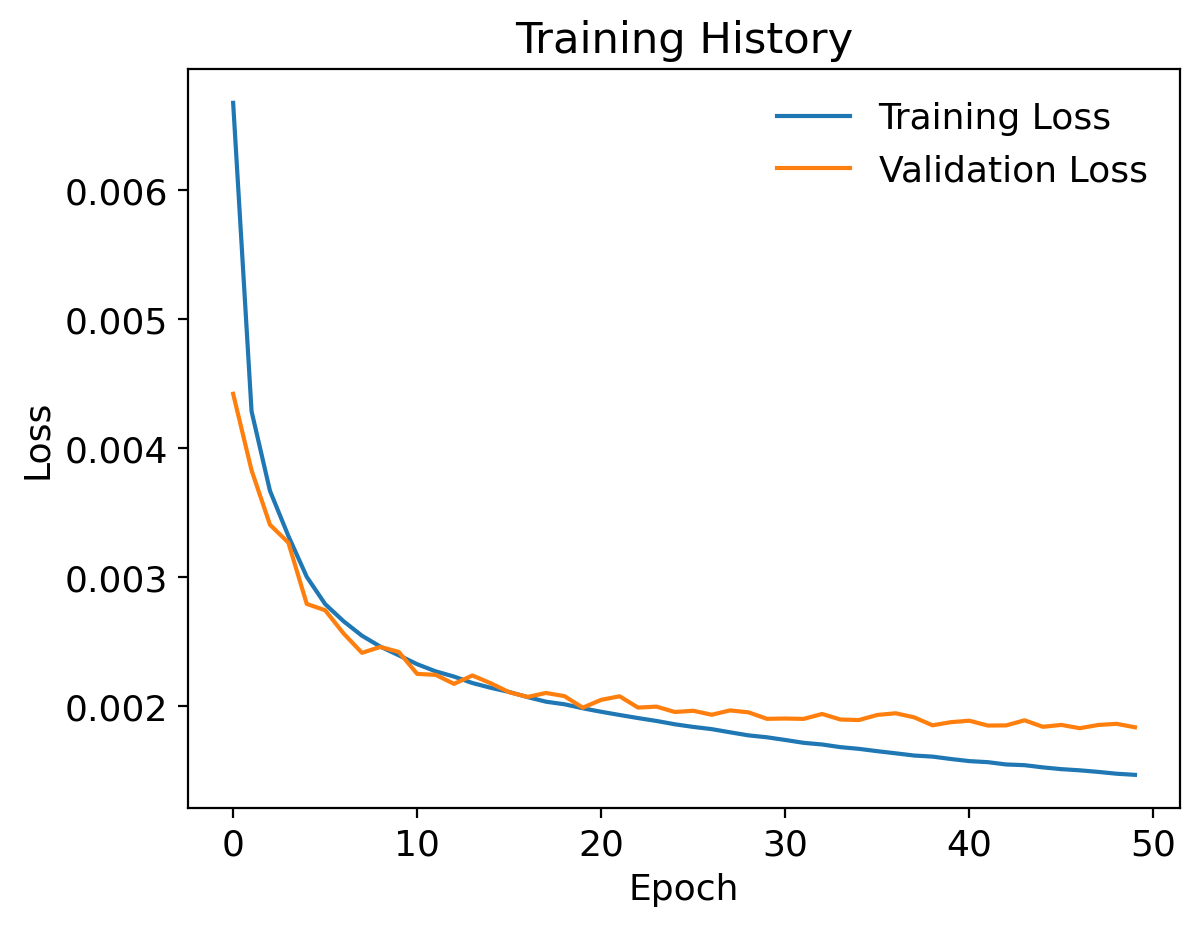

In [108]:
plot_history(train_losses_mse, val_losses_mse)

In [109]:
model_path = os.path.join(cwd, 'saved_model')
make_dir(model_path)

In [110]:
# Save the model weights to a pth file.
torch.save(model.state_dict(), os.path.join(model_path, 'LSTM_model_weights.pth'))

### 5. Evaluate the trained model

In [111]:
# make new model instances for evaluation (best practice)
model_eval = LSTMModel(
    input_size=X_train_seq.shape[2],
    hidden_size=n_neuron,
    output_size=y_train_seq.shape[-1],
    num_layers=2
)

# reload the saved model weights
state_dict = torch.load(os.path.join(model_path, 'LSTM_model_weights.pth'), weights_only=True)
model_eval.load_state_dict(state_dict)

<All keys matched successfully>

In [112]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=minibatch_size, shuffle=False)

model_eval.to(device).eval()
predictions = []
with torch.no_grad():
    for batch_X, in test_loader:
        batch_X = batch_X.to(device)
        outputs = model_eval(batch_X)
        predictions.append(outputs.cpu().numpy())

In [113]:
y_pred = np.concatenate(predictions, axis=0).flatten()
y_true = y_test_seq.flatten()

print("Predictions shape:", y_pred.shape)
print("True values shape:", y_true.shape)

Predictions shape: (3519864,)
True values shape: (3519864,)


In [114]:
# Calculate RMSE
rmse = np.sqrt(np.mean((y_pred - y_true)**2))
print(f"Test RMSE: {rmse:.4f}")

Test RMSE: 0.0763


#### Visualize predictions vs truth

In [115]:
# Reconstruct predictions into xarray Dataset for the full polar test region
n_lat = len(ds_test.latitude)
n_lon = len(ds_test.longitude)
n_time_test = len(ds_test.time)

# Initialize with NaN
ice_pred_grid = np.full((n_time_test, n_lat, n_lon), np.nan)

# The space dimension was stacked as (latitude, longitude)
# So s_idx maps to: lat_idx = s_idx // n_lon, lon_idx = s_idx % n_lon

for i in range(len(y_pred)):
    t_idx, s_idx = meta_test[i]
    lat_idx = s_idx // n_lon
    lon_idx = s_idx % n_lon
    
    if 0 <= t_idx < n_time_test and 0 <= lat_idx < n_lat and 0 <= lon_idx < n_lon:
        ice_pred_grid[t_idx, lat_idx, lon_idx] = y_pred[i]

# Check how many values were filled
valid_count = np.sum(~np.isnan(ice_pred_grid))
total_count = ice_pred_grid.size
print(f"Filled {valid_count} / {total_count} grid points ({100*valid_count/total_count:.1f}%)")

# Create xarray Dataset for predictions (full polar region)
y_test_pre = xr.Dataset(
    coords={
        'time': ds_test.time.values,
        'latitude': ds_test.latitude.values,
        'longitude': ds_test.longitude.values
    },
    data_vars={
        'ice': (['time', 'latitude', 'longitude'], ice_pred_grid)
    }
)

# Filter to GREENLAND for visualization
greenland_lat_min, greenland_lat_max = 60, 85
greenland_lon_min, greenland_lon_max = -65, -10

y_test_pre_greenland = y_test_pre.sel(
    latitude=slice(greenland_lat_max, greenland_lat_min),
    longitude=slice(greenland_lon_min, greenland_lon_max)
)

ds_test_greenland = ds_test.sel(
    latitude=slice(greenland_lat_max, greenland_lat_min),
    longitude=slice(greenland_lon_min, greenland_lon_max)
)

print(f"Greenland subset shape: {y_test_pre_greenland.ice.shape}")


Filled 3519864 / 6156000 grid points (57.2%)
Greenland subset shape: (190, 25, 55)


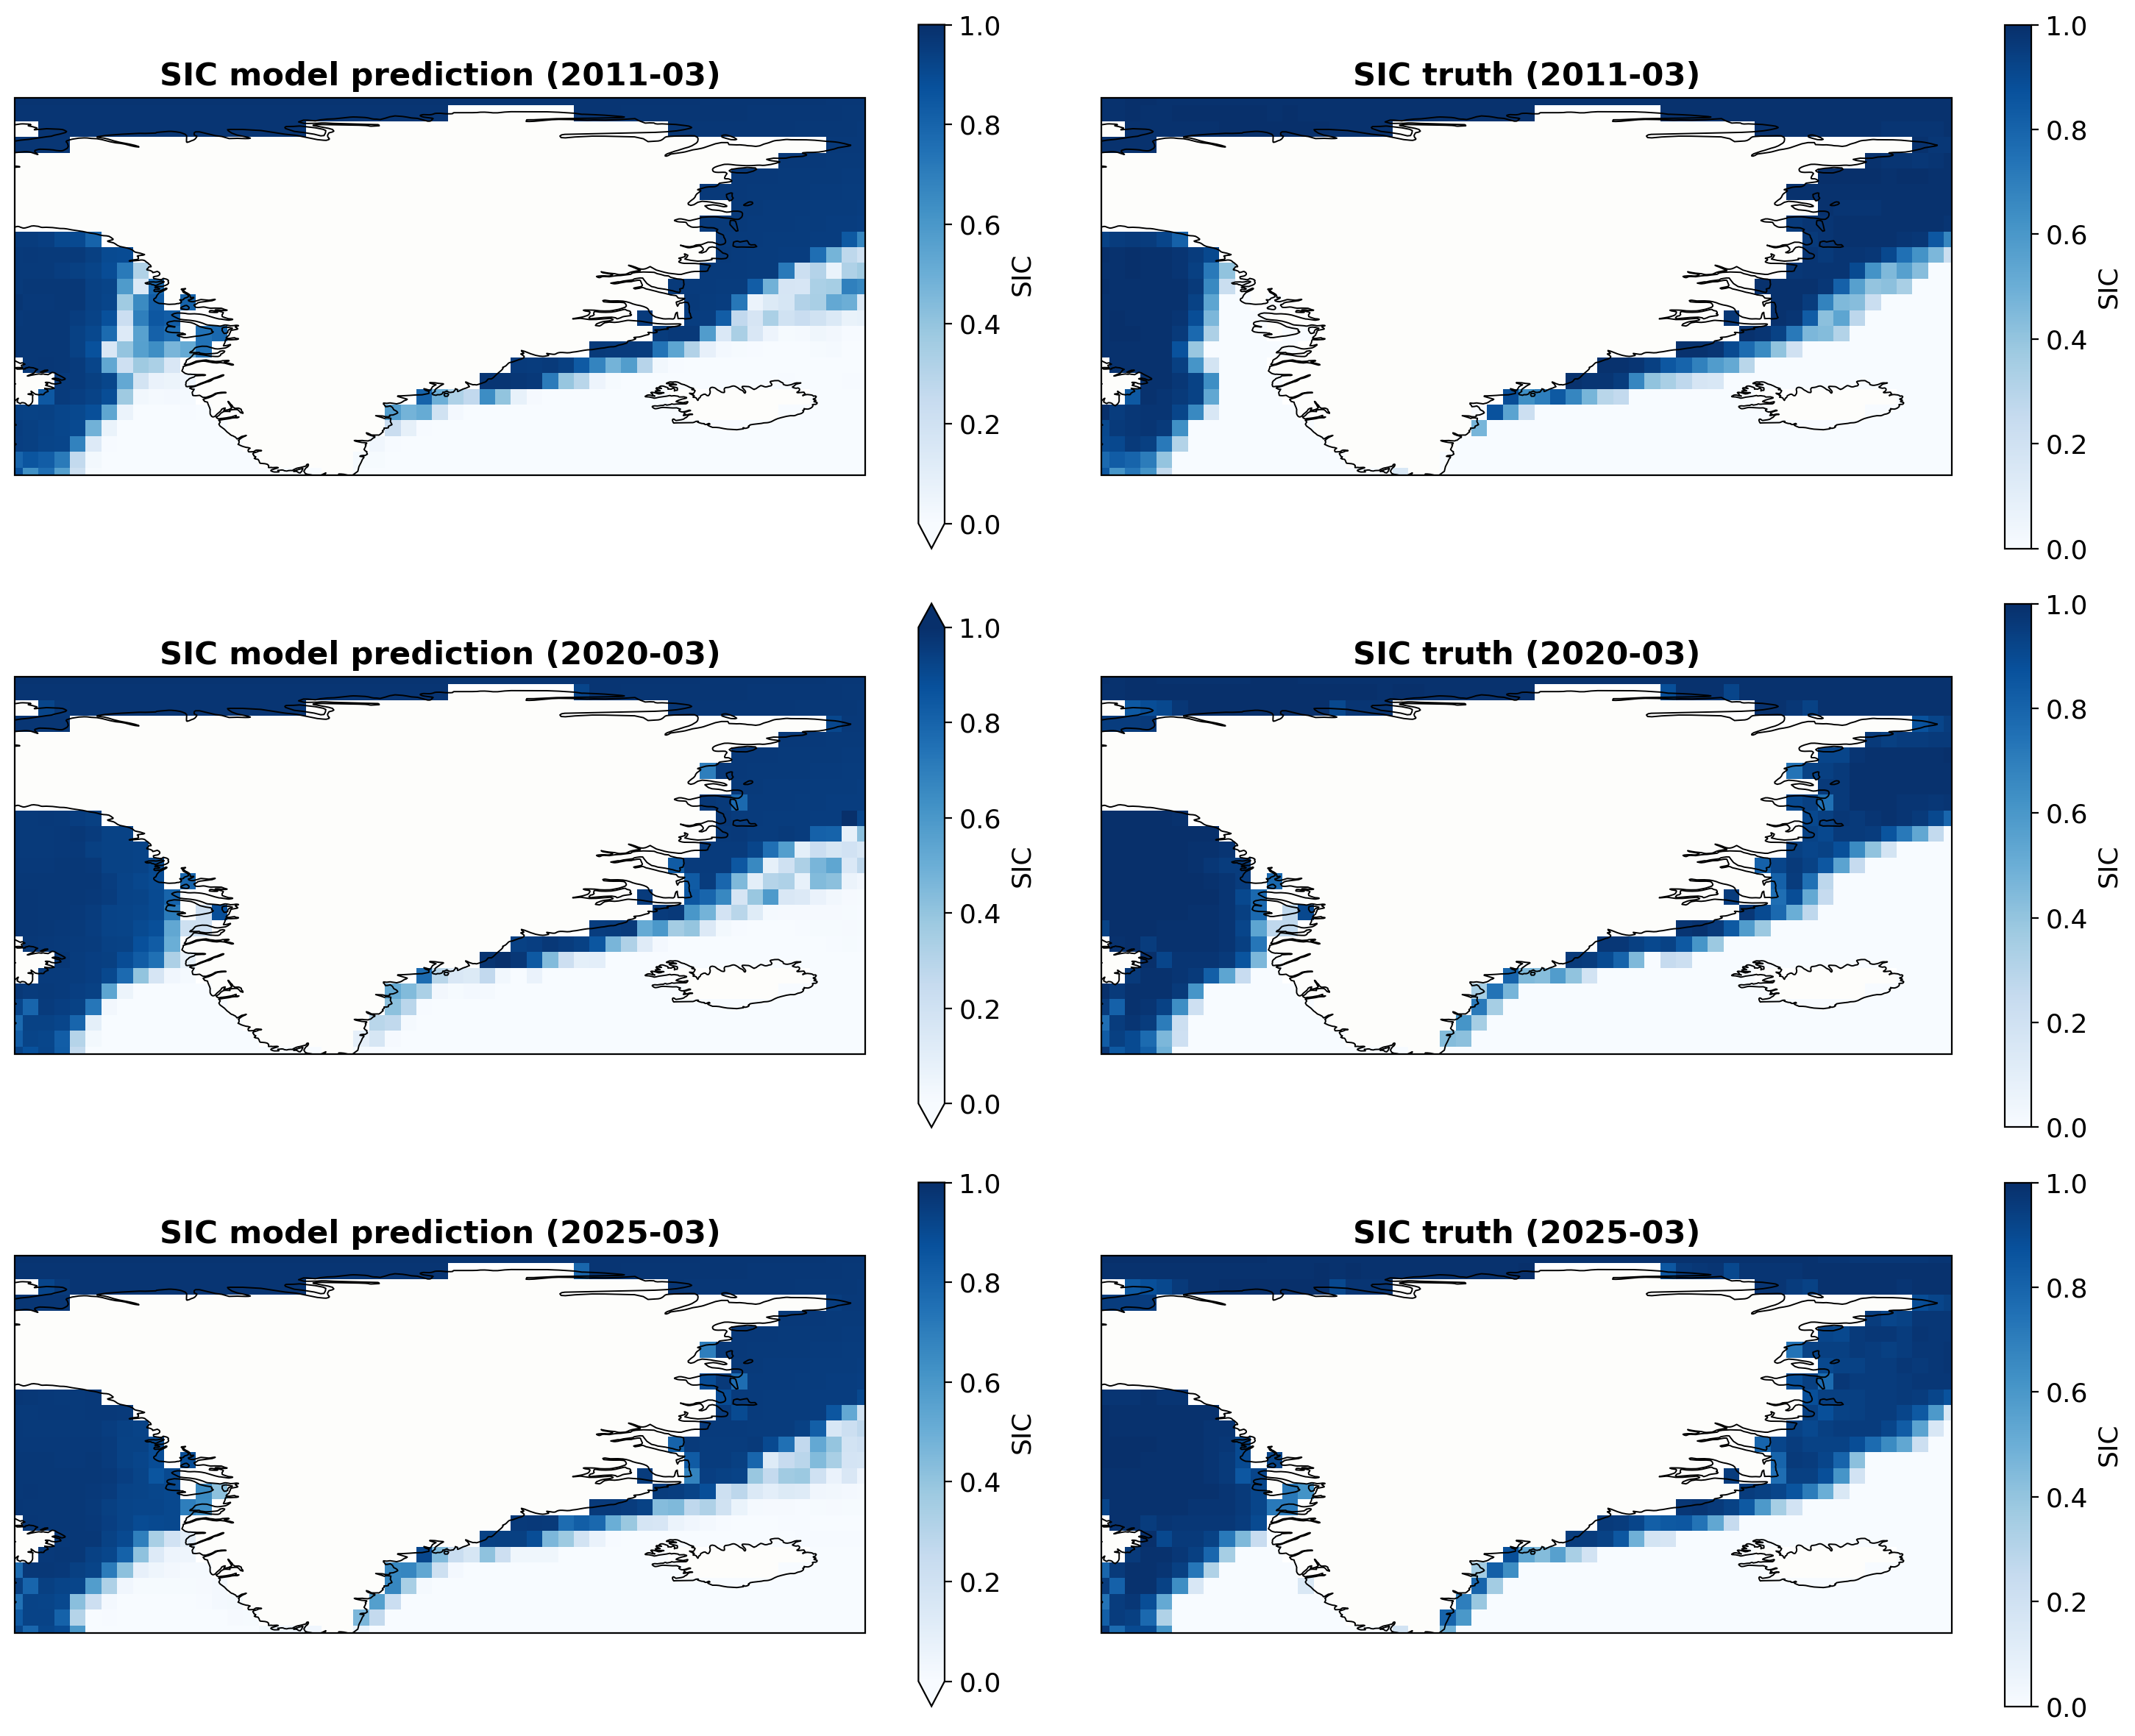

In [120]:
# If you don't already have cartopy, install it first (in Colab):
# !pip install cartopy

import cartopy.crs as ccrs
import cartopy.feature as cfeature

# --- choose month to visualize (1 = Jan, ..., 12 = Dec) ---
target_month = 3   # change this to whatever month you want
month_str = f"{target_month:02d}"

years = [2011, 2020, 2025]
vmin, vmax = 0, 1
cmap = 'Blues'

# Get extent from Greenland subset
lon_min = float(ds_test_greenland.longitude.min())
lon_max = float(ds_test_greenland.longitude.max())
lat_min = float(ds_test_greenland.latitude.min())
lat_max = float(ds_test_greenland.latitude.max())

proj = ccrs.PlateCarree()

fig, axes = plt.subplots(
    figsize=(15, 12),
    ncols=2,
    nrows=len(years),
    subplot_kw={'projection': proj}
)

for i, yr in enumerate(years):
    time_sel = f"{yr}-{month_str}"

    # ---------- Prediction (left column) ----------
    pred_data = y_test_pre_greenland.ice.sel(time=time_sel, method='nearest')
    pred_data.plot(
        ax=axes[i, 0],
        vmin=vmin, vmax=vmax, cmap=cmap,
        cbar_kwargs={'label': 'SIC'},
        transform=ccrs.PlateCarree()  # data is in lat/lon
    )
    axes[i, 0].set_title(f'SIC model prediction ({yr}-{month_str})', fontweight='bold')
    axes[i, 0].set_xlabel('longitude')
    axes[i, 0].set_ylabel('latitude')

    # add Greenland / coastline outline
    axes[i, 0].coastlines(resolution='50m', linewidth=0.7)
    axes[i, 0].add_feature(cfeature.LAND, alpha=0.1)
    axes[i, 0].set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

    # ---------- Truth (right column) ----------
    truth_data = ds_test_greenland.ice.sel(time=time_sel, method='nearest')
    truth_data = truth_data.where((truth_data >= 0) & (truth_data <= 1))

    truth_data.plot(
        ax=axes[i, 1],
        vmin=vmin, vmax=vmax, cmap=cmap,
        cbar_kwargs={'label': 'SIC'},
        transform=ccrs.PlateCarree()
    )
    axes[i, 1].set_title(f'SIC truth ({yr}-{month_str})', fontweight='bold')
    axes[i, 1].set_xlabel('longitude')
    axes[i, 1].set_ylabel('latitude')

    # coastline + land for Greenland outline
    axes[i, 1].coastlines(resolution='50m', linewidth=0.7)
    axes[i, 1].add_feature(cfeature.LAND, alpha=0.1)
    axes[i, 1].set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

plt.tight_layout()
plt.show()


Calculating spatial RMSE map...


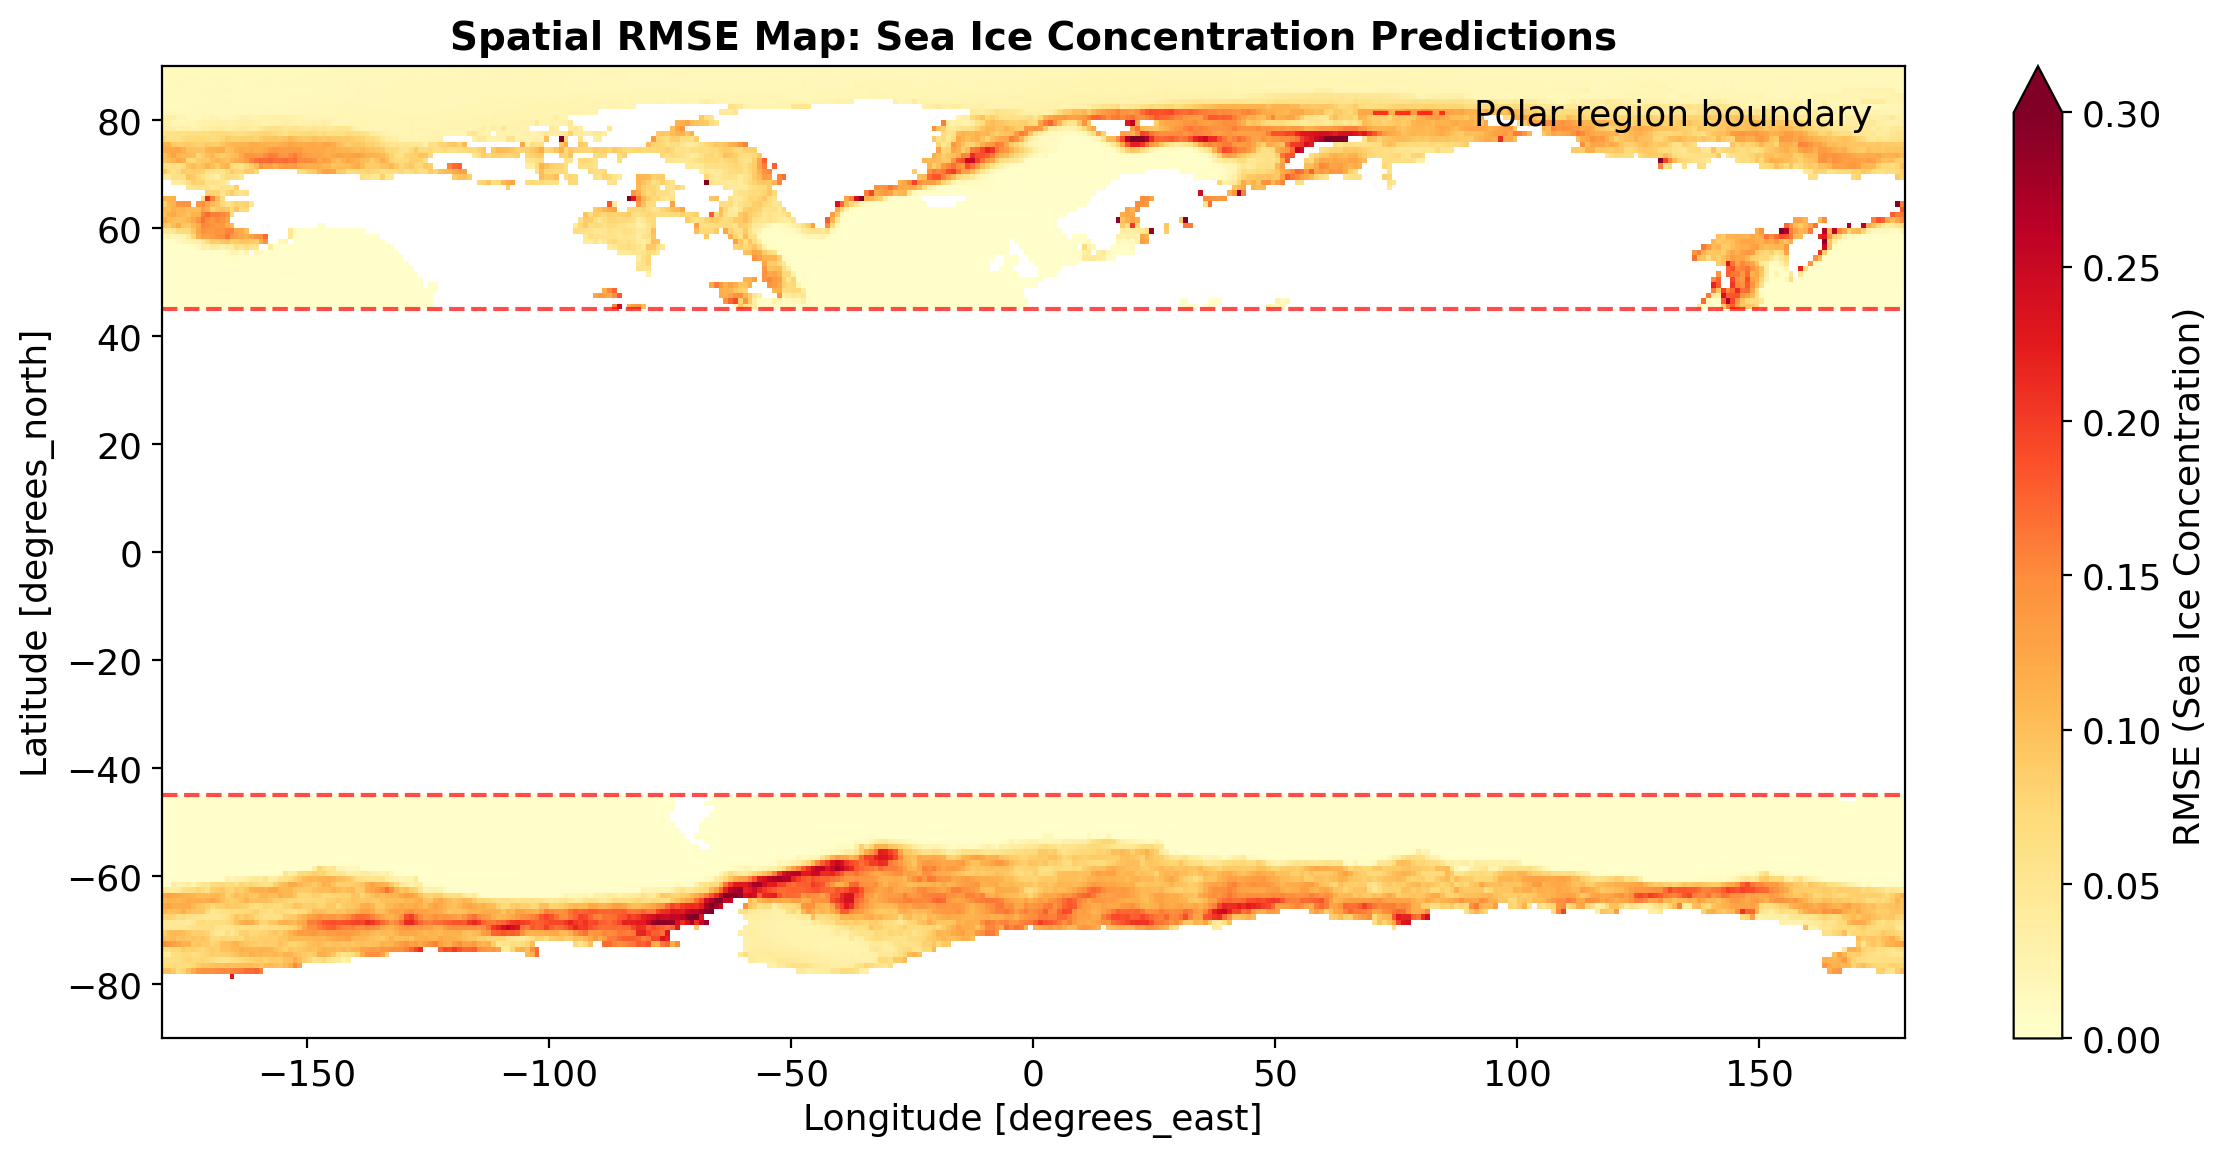

In [117]:
# Calculate spatial RMSE map (RMSE at each grid point across all time steps)
print("Calculating spatial RMSE map...")

# First, we need to expand predictions back to full global grid with NaNs in mid-latitudes
# Get the full latitude range from the original dataset
ds_sst_full = xr.open_dataset(data_dir / "HadISST_sst.nc")
full_lats = ds_sst_full.latitude.values
full_lons = ds_sst_full.longitude.values

# Create full grid arrays initialized with NaN
n_time = len(ds_test.time)
n_lat_full = len(full_lats)
n_lon_full = len(full_lons)

ice_pred_grid_full = np.full((n_time, n_lat_full, n_lon_full), np.nan)
y_test_grid_full = np.full((n_time, n_lat_full, n_lon_full), np.nan)

# Fill in only the polar regions
# Find indices for polar latitudes in the full grid
polar_lat_indices = np.where((full_lats >= 45) | (full_lats <= -45))[0]

# Map the polar data to the correct positions in the full grid
for i, lat_idx in enumerate(polar_lat_indices):
    ice_pred_grid_full[:, lat_idx, :] = ice_pred_grid[:, i, :]
    y_test_grid_full[:, lat_idx, :] = y_test_raw.reshape(n_time, len(ds_test.latitude), len(ds_test.longitude))[:, i, :]

# Create xarray DataArrays with full grid
ice_pred_xr = xr.DataArray(
    ice_pred_grid_full,
    coords={
        'time': ds_test.time,
        'latitude': full_lats,
        'longitude': full_lons
    },
    dims=['time', 'latitude', 'longitude']
)

y_test_xr = xr.DataArray(
    y_test_grid_full,
    coords={
        'time': ds_test.time,
        'latitude': full_lats,
        'longitude': full_lons
    },
    dims=['time', 'latitude', 'longitude']
)

# Calculate squared differences at each grid point for each time step
squared_diff = (ice_pred_xr - y_test_xr) ** 2

# Calculate RMSE at each spatial location (mean over time, then sqrt)
spatial_rmse = np.sqrt(squared_diff.mean(dim='time', skipna=True))

# Create the spatial RMSE plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the spatial RMSE
spatial_rmse.plot(ax=ax, cmap='YlOrRd', vmin=0, vmax=0.3, 
                  cbar_kwargs={'label': 'RMSE (Sea Ice Concentration)'})

# Add red lines at polar cutoff
ax.axhline(45, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='Polar region boundary')
ax.axhline(-45, color='red', linestyle='--', linewidth=1.5, alpha=0.7)

ax.set_title('Spatial RMSE Map: Sea Ice Concentration Predictions', fontweight='bold', fontsize=14)
ax.set_xlabel('Longitude [degrees_east]')
ax.set_ylabel('Latitude [degrees_north]')
ax.legend()

plt.tight_layout()
plt.show()

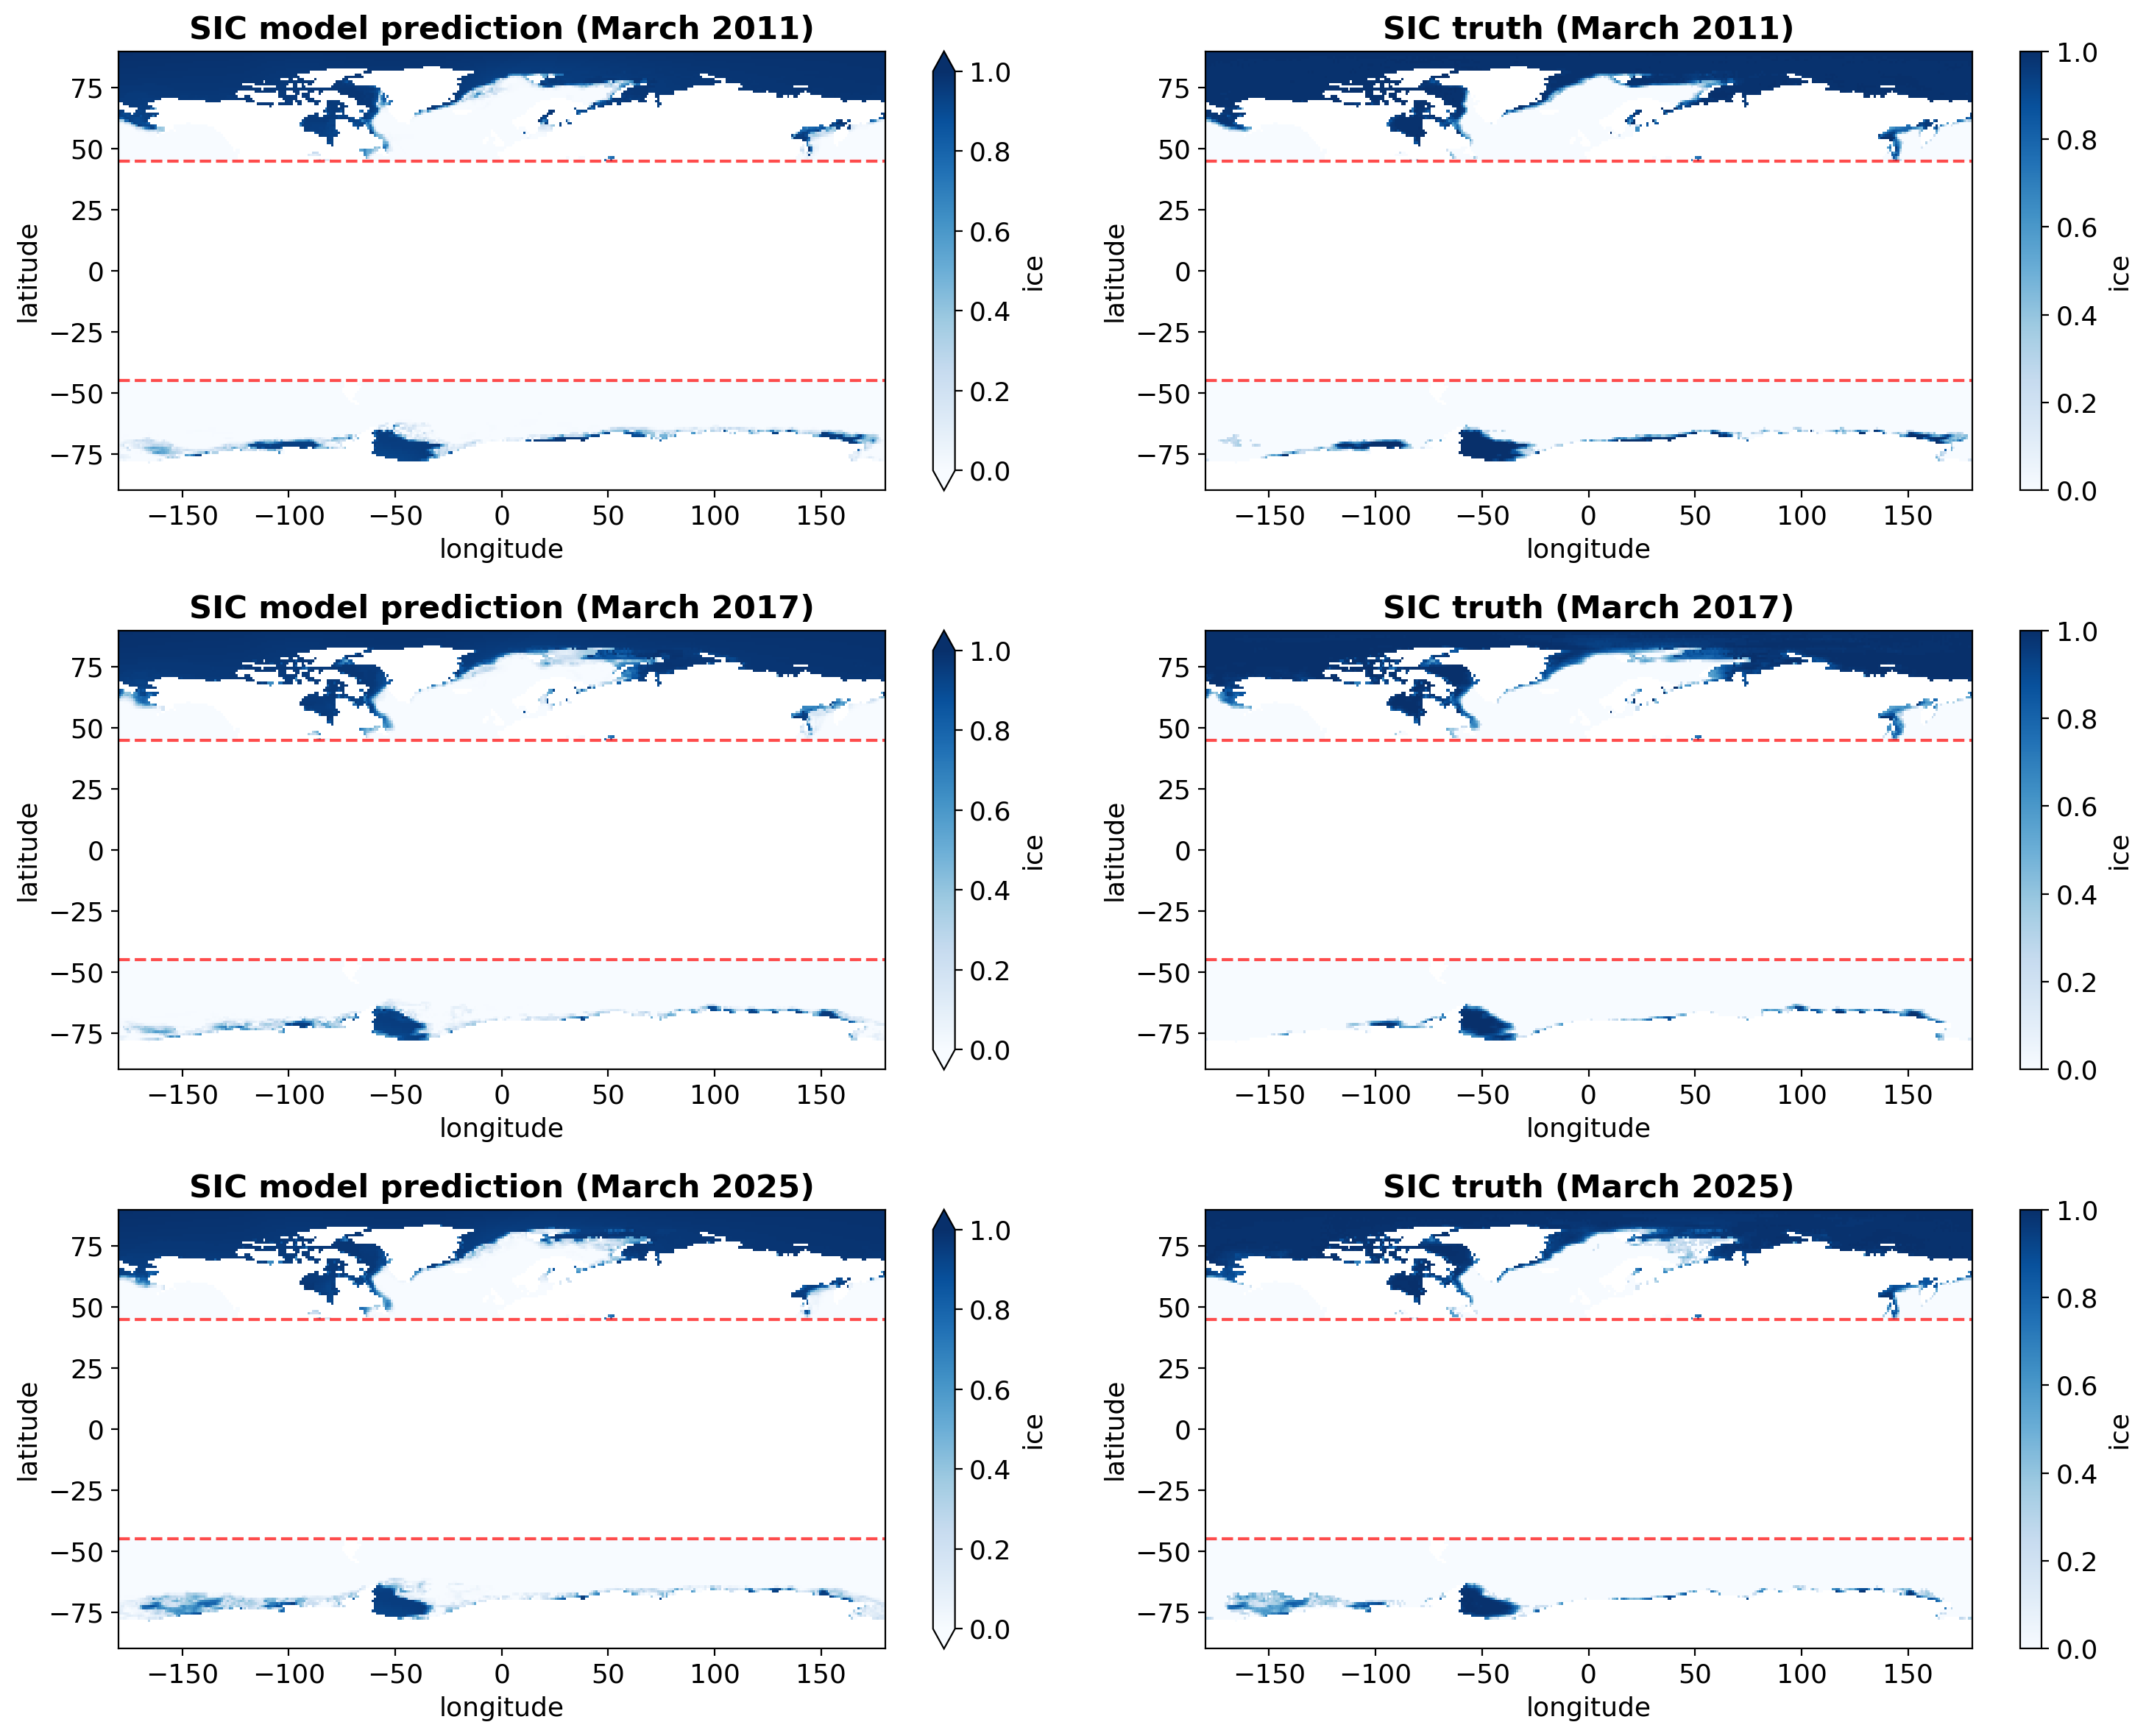

In [118]:
# Visualize predictions vs truth for selected years (matching RF format with full grid)
# First, expand predictions back to full global grid with NaNs in mid-latitudes
ds_sst_full = xr.open_dataset(data_dir / "HadISST_sst.nc")
full_lats = ds_sst_full.latitude.values
full_lons = ds_sst_full.longitude.values

# Create full grid arrays initialized with NaN
n_time = len(ds_test.time)
n_lat_full = len(full_lats)
n_lon_full = len(full_lons)

ice_pred_grid_full = np.full((n_time, n_lat_full, n_lon_full), np.nan)
y_test_grid_full = np.full((n_time, n_lat_full, n_lon_full), np.nan)

# Find indices for polar latitudes in the full grid
polar_lat_indices = np.where((full_lats >= 45) | (full_lats <= -45))[0]

# Map the polar data to the correct positions in the full grid
for i, lat_idx in enumerate(polar_lat_indices):
    ice_pred_grid_full[:, lat_idx, :] = ice_pred_grid[:, i, :]
    y_test_grid_full[:, lat_idx, :] = y_test_raw.reshape(n_time, len(ds_test.latitude), len(ds_test.longitude))[:, i, :]

# Create xarray Dataset for predictions with full grid
y_test_pred_xr = xr.Dataset(
    data_vars={
        'ice': (['time', 'latitude', 'longitude'], ice_pred_grid_full)
    },
    coords={
        'time': ds_test.time,
        'latitude': full_lats,
        'longitude': full_lons
    }
)

# Create xarray Dataset for truth with full grid
ds_test_full = xr.Dataset(
    data_vars={
        'ice': (['time', 'latitude', 'longitude'], y_test_grid_full)
    },
    coords={
        'time': ds_test.time,
        'latitude': full_lats,
        'longitude': full_lons
    }
)

# Now plot using the same format as RF notebook
fig, axes = plt.subplots(figsize=(15, 12), ncols=2, nrows=3)

# Select specific dates: March 2011, 2017, and 2025
dates = ['2011-03', '2017-03', '2025-03']

vmin, vmax = 0, 1  # Sea ice concentration ranges from 0 to 1
cmap = 'Blues'

# Plot predictions and truth for each date
y_test_pred_xr.ice.sel(time=dates[0], method='nearest').plot(
    ax=axes[0,0], vmin=vmin, vmax=vmax, cmap=cmap)
ds_test_full.ice.sel(time=dates[0], method='nearest').plot(
    ax=axes[0,1], vmin=vmin, vmax=vmax, cmap=cmap)

y_test_pred_xr.ice.sel(time=dates[1], method='nearest').plot(
    ax=axes[1,0], vmin=vmin, vmax=vmax, cmap=cmap)
ds_test_full.ice.sel(time=dates[1], method='nearest').plot(
    ax=axes[1,1], vmin=vmin, vmax=vmax, cmap=cmap)

y_test_pred_xr.ice.sel(time=dates[2], method='nearest').plot(
    ax=axes[2,0], vmin=vmin, vmax=vmax, cmap=cmap)
ds_test_full.ice.sel(time=dates[2], method='nearest').plot(
    ax=axes[2,1], vmin=vmin, vmax=vmax, cmap=cmap)

# Set titles and add red lines at cutoff latitudes
years = [2011, 2017, 2025]
for i, ax in enumerate(axes.flat):
    if i % 2 == 0:
        ax.set_title(f'SIC model prediction (March {years[i//2]})', fontweight='bold')
    else:
        ax.set_title(f'SIC truth (March {years[i//2]})', fontweight='bold')
    
    # Add red horizontal lines at ±45° latitude cutoffs
    ax.axhline(45, color='red', linestyle='--', linewidth=1.5, alpha=0.7)
    ax.axhline(-45, color='red', linestyle='--', linewidth=1.5, alpha=0.7)

plt.tight_layout()